In [206]:
add_labels(df)

,id,domain,orig_type,type,scraped_at,words,content_len,mean_word_len,median_word_len,split
0,34,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'headlin': 1, 'bitcoin': 1, 'blockchain': 2, ...",1574,5.381743,4.0,3
1,35,beforeitsnews.com,reliable,reliable,2018-01-25 16:17:44.789555,"{'water': 2, 'cooler': 2, '<number><number><nu...",6647,5.081418,4.0,4
2,36,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'veteran': 2, 'comment': 8, 'call': 5, 'grow'...",3144,4.596525,4.0,7
3,37,beforeitsnews.com,bias,fake,2018-01-25 16:17:44.789555,"{'lost': 6, 'word': 8, 'hidden': 3, 'bank': 4,...",3587,4.348983,4.0,8
4,39,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'scientist': 13, 'move': 11, 'doomsday': 19, ...",17970,5.380292,5.0,10
...,...,...,...,...,...,...,...,...,...,...
995,4629,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'inflat': 4, 'watch': 2, 'bond': 2, 'market':...",730,5.391753,5.0,10
996,4630,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'portfolio': 4, 'look': 8, 'tempt': 1, 'follo...",6925,4.930314,4.0,7
997,4632,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'pharmaceut': 2, 'synthet': 4, 'flu': 11, 'va...",2656,5.643799,5.0,3
998,4633,beforeitsnews.com,fake,fake,2018-01-25 16:17:44.789555,"{'merger': 4, 'creat': 2, 'powerhous': 2, 'say...",1697,5.662393,5.0,5


Source: https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/

In [4]:
labels = {
    "fake": "fake",
    "bias": "fake",
    "junksci": "fake",
    "hate": "fake",
    "reliable": "reliable"
}

def add_labels(df) -> pd.DataFrame:
    """Add custom labels based on 'type' column to dataframe."""
    df = df.rename(columns={"type":"orig_type"})
    
    def lookup_labels(data) -> str:
        return labels[data["orig_type"]]
    df["type"] = df.apply(lookup_labels, axis=1)

    new_index = ["id", "domain", "orig_type","type", "scraped_at", "words", "content_len", "mean_word_len", "median_word_len", "split"]
    df = df.reindex(columns= new_index)
    return df

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pl
import os

In [2]:
df_src = pd.read_csv(pl.Path(os.path.abspath('')).parent.parent.resolve() / "data_files/processed_csv/summarized_corpus_valset2_groups.csv")

In [3]:
df = df_src.copy()
df.head()

,id,domain,orig_type,scraped_at,type,words,content_len,mean_word_len,median_word_len,split
0,9684638.0,nytimes.com,reliable,2018-02-11 00:48:01.619836,reliable,"{'petti': 3, 'complet': 1, 'pass': 5, 'cotton'...",3322,5.026408,4.0,6
1,8486467.0,nytimes.com,reliable,2018-02-11 00:36:08.462112,reliable,"{'outset': 1, 'first': 2, 'match': 2, 'pilot':...",1264,5.458128,5.0,7
2,8699302.0,nytimes.com,reliable,2018-02-11 00:38:14.808471,reliable,"{'baton': 1, 'roug': 1, 'man': 2, 'forc': 1, '...",467,4.376471,4.0,8
3,8997443.0,nytimes.com,reliable,2018-02-11 00:41:07.513779,reliable,"{'daughter': 1, 'dr': 2, 'paul': 1, 'ny': 3, '...",1001,5.119497,5.0,9
4,1862051.0,pravda.ru,bias,2017-11-10T11:18:44.524042,fake,"{'na': 8, 'ukrain': 1, 'nachali': 1, 'rossiisk...",1820,7.543379,7.0,8


In [4]:
df

,id,domain,orig_type,scraped_at,type,words,content_len,mean_word_len,median_word_len,split
0,9684638.0,nytimes.com,reliable,2018-02-11 00:48:01.619836,reliable,"{'petti': 3, 'complet': 1, 'pass': 5, 'cotton'...",3322,5.026408,4.0,6
1,8486467.0,nytimes.com,reliable,2018-02-11 00:36:08.462112,reliable,"{'outset': 1, 'first': 2, 'match': 2, 'pilot':...",1264,5.458128,5.0,7
2,8699302.0,nytimes.com,reliable,2018-02-11 00:38:14.808471,reliable,"{'baton': 1, 'roug': 1, 'man': 2, 'forc': 1, '...",467,4.376471,4.0,8
3,8997443.0,nytimes.com,reliable,2018-02-11 00:41:07.513779,reliable,"{'daughter': 1, 'dr': 2, 'paul': 1, 'ny': 3, '...",1001,5.119497,5.0,9
4,1862051.0,pravda.ru,bias,2017-11-10T11:18:44.524042,fake,"{'na': 8, 'ukrain': 1, 'nachali': 1, 'rossiisk...",1820,7.543379,7.0,8
...,...,...,...,...,...,...,...,...,...,...
2774314,9153728.0,nytimes.com,reliable,2018-02-11 00:42:35.664094,reliable,"{'market': 1, 'look': 2, 'direct': 1, 'recent'...",1489,4.968127,4.0,3
2774315,9870712.0,nytimes.com,reliable,2018-02-11 00:49:45.199995,reliable,"{'how': 2, 'think': 1, 'feel': 2, 'prison': 5,...",318,4.096774,3.0,5
2774316,9140554.0,nytimes.com,reliable,2018-02-11 00:42:28.789188,reliable,"{'chart': 2, 'articl': 1, 'wednesday': 1, 'leg...",254,5.243902,4.0,8
2774317,NaN,nytimes.com,reliable,2018-02-11 00:49:52.111090,reliable,"{'hous': 13, 'author': 13, 'resid': 4, 'audien...",6261,4.996098,4.0,5


In [28]:
# print(len(df))
# df = df.rename(columns={"type":"orig_type"})
# df['type'] = df['orig_type']
# update df to only contain duplicates
# print("\n Extracting duplicate rows... This may take up to a minute...")
# df_incl_dups = len(df)
# df = df[df.duplicated(subset=["words","content_len"], keep='first') == True] # does not include "scraped_at" in subset argument, so an article scraped on several occasions will only have the first occurence as non-duplicate
# df_excl_dups = len(df)
# diff = df_incl_dups - df_excl_dups
# print(f"Total duplicates found: {diff}")
# df

2774319


,id,domain,orig_type,scraped_at,type,words,content_len,mean_word_len,median_word_len,split
3715,2952189.0,conservapedia.com,bias,2017-11-18T20:01:27.400599,fake,"{'jump': 1, 'navig': 1, 'link': 3, 'here': 1, ...",520,5.388235,4.0,4
6946,8122505.0,uk.finance.yahoo.com,reliable,2016-11-30T01:09:57.105+02:00,reliable,"{'relat': 1, 'quot': 1, 'symbol': 1, 'price': ...",67,6.363636,6.0,8
7048,8209402.0,uk.finance.yahoo.com,reliable,2016-11-07T11:09:00.098+02:00,reliable,"{'relat': 1, 'quot': 1, 'symbol': 1, 'price': ...",55,6.250000,6.0,7
9161,8303673.0,uk.finance.yahoo.com,reliable,2016-11-18T11:23:07.442+02:00,reliable,"{'relat': 1, 'quot': 1, 'symbol': 1, 'price': ...",55,6.500000,6.0,6
10913,2531746.0,conservapedia.com,bias,2017-11-13T18:09:27.760857,fake,"{'jump': 1, 'navig': 1, 'link': 3, 'here': 1, ...",521,5.400000,4.0,6
...,...,...,...,...,...,...,...,...,...,...
2773548,8005040.0,news.yahoo.com,reliable,2016-11-25T01:13:52.309+02:00,reliable,"{'vera': 1, 'john': 1, 'miller': 1, 'reuter': ...",4317,5.107195,5.0,10
2773741,3229769.0,beforeitsnews.com,fake,2017-11-18T20:01:27.400599,fake,"{'travel': 1, 'monday': 1, 'may': 1, '<number>...",41,6.555556,6.0,9
2773765,2919357.0,conservapedia.com,bias,2017-11-18T20:01:27.400599,fake,"{'jump': 1, 'navig': 1, 'link': 3, 'here': 1, ...",529,5.470588,4.0,7
2773782,8151179.0,uk.finance.yahoo.com,reliable,2016-11-06T11:57:03.797+02:00,reliable,"{'istanbul': 3, 'ap': 1, 'suspect': 5, 'motorc...",1662,5.355212,5.0,3


In [5]:
df.type.value_counts()

reliable    1438023
fake        1336296
Name: type, dtype: int64

In [6]:
reals = df.type.value_counts()[0]
fakes = df.type.value_counts()[1]
print(f"Fake article percentage: {fakes/(fakes+reals)}")

Fake article percentage: 0.48166631162458245


Fake-to-Reliable article ratio for top 1500000 articles: 1.0768949589605556
Fake-to-Reliable article ratio for top 1400000 articles: 1.0771174357688524
Fake-to-Reliable article ratio for top 1300000 articles: 1.07724806176777
Fake-to-Reliable article ratio for top 1200000 articles: 1.0777241994268945
Fake-to-Reliable article ratio for top 1100000 articles: 1.0779652564209126


<Axes: xlabel='type', ylabel='count'>

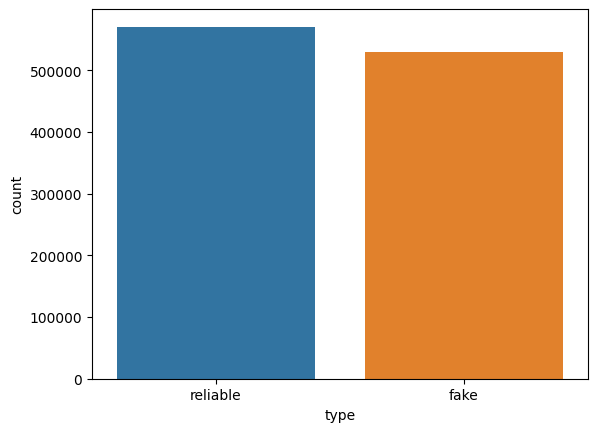

In [8]:
# df reduction to 200.000 articles; approx 1/10th
fakes_list = []
reals_list = []
for i in range(5):
    count = 1_500_000 - i*100000
    df2 = df[:count]
    df2_len = len(df2)
    fakes = df2.type.value_counts()[0]
    reals = df2.type.value_counts()[1]
    
    print(f"Fake-to-Reliable article ratio for top {df2_len} articles: {fakes/reals}")
sns.countplot(data=df2,
              x='type',
              order=df2['type'].value_counts().index)

In [ ]:
## Fake-to-Reliable article ratio for only fake vs. reliable labels (results)

# Fake-to-Realiable article ratio for top 1500000 articles: 1.4397344918277026
# Fake-to-Realiable article ratio for top 1400000 articles: 1.2770855257058558
# Fake-to-Realiable article ratio for top 1300000 articles: 1.1144365595840091
# Fake-to-Realiable article ratio for top 1200000 articles: 1.05065458603265
# Fake-to-Realiable article ratio for top 1100000 articles: 1.2672044750494147
# Fake-to-Realiable article ratio for top 1000000 articles: 1.596195535062919
# Fake-to-Realiable article ratio for top  900000 articles: 2.1559126022603348
# Fake-to-Realiable article ratio for top  800000 articles: 3.3201442928193803
# Fake-to-Realiable article ratio for top  700000 articles: 7.217988001737518
# Fake-to-Realiable article ratio for top  600000 articles: 31.298002906820262
# Fake-to-Realiable article ratio for top  500000 articles: 26.207922947162213
# Fake-to-Realiable article ratio for top  400000 articles: 22.88630120625821
# Fake-to-Realiable article ratio for top  300000 articles: 17.2882223847842
# Fake-to-Realiable article ratio for top  200000 articles: 17.08481779546071
# Fake-to-Realiable article ratio for top  100000 articles: 21.232103156958647

In [ ]:
# Fake-to-Reliable article ratio for large label groups fake=(bias, fake, hate, junksci) vs reliable=(reliable)

# Fake-to-Reliable article ratio for top 1500000 articles: 7.713483243971722
# Fake-to-Reliable article ratio for top 1400000 articles: 18.404826257502044
# Fake-to-Reliable article ratio for top 1300000 articles: 73.2560118809619
# Fake-to-Reliable article ratio for top 1200000 articles: 67.55575868372944
# Fake-to-Reliable article ratio for top 1100000 articles: 65.05813115541676
# Fake-to-Reliable article ratio for top 1000000 articles: 61.77857994852157
# Fake-to-Reliable article ratio for top 900000 articles: 55.857666308673956
# Fake-to-Reliable article ratio for top 800000 articles: 50.20655443896819
# Fake-to-Reliable article ratio for top 700000 articles: 44.31624263611057
# Fake-to-Reliable article ratio for top 600000 articles: 43.923629829290206
# Fake-to-Reliable article ratio for top 500000 articles: 50.26627704296114
# Fake-to-Reliable article ratio for top 400000 articles: 52.10674455655868
# Fake-to-Reliable article ratio for top 300000 articles: 49.55611729019211
# Fake-to-Reliable article ratio for top 200000 articles: 47.33252779120348
# Fake-to-Reliable article ratio for top 100000 articles: 70.99424046076314

In [9]:
df['orig_type'].value_counts()

reliable    1438023
bias         612078
fake         609753
junksci       62371
hate          52094
Name: orig_type, dtype: int64

In [1]:
# # Shuffling
# df = df.sample(frac=1)
# df.reset_index(inplace=True)
# df.drop(["index"], axis=1, inplace=True)

NameError: name 'df' is not defined

### Preprocessing and analysis of News column

- Indhent de to dataframes
- - oprindelige data: id, type
- - splits: id, split
- Merge de to dataframes og sammenlign med 
- - merge ( on="id", left-merge eller inner <- interesction)
- Sort på duplicate id lookup == True
- type.value_counts()
- evt. to_csv så vi har dataen

In [10]:
df2 = df.copy()

In [11]:
import ast
print(type(df2.words[0]))
df2['words'] = df2['words'].apply(ast.literal_eval)
print(type(df2.words[0]))

<class 'str'>


In [92]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = DictVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(df2['words'].tolist(), 30)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

AttributeError: 'str' object has no attribute 'items'

In [50]:
# Use DictVectorizer to transform bag_of_words column
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()

D = df2['words']
bag_of_words_matrix = vectorizer.fit_transform(D)

In [51]:
bag_of_words_matrix

<20000x13675 sparse matrix of type '<class 'numpy.float64'>'
	with 3409732 stored elements in Compressed Sparse Row format>

In [52]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()
feature_names[4340:4360]

array(['farfetch', 'farflung', 'fargo', 'farley', 'farm', 'farmer',
       'farmhous', 'farmingdal', 'farmland', 'farrar', 'farreach',
       'farrel', 'farright', 'farther', 'fascin', 'fascism', 'fascist',
       'fashion', 'faso', 'fassel'], dtype=object)

In [53]:
# Convert matrix to dataframe
bag_of_words_df = pd.DataFrame.sparse.from_spmatrix(bag_of_words_matrix, columns=feature_names)

In [54]:
# Concatenate article_id column and bag_of_words_df
result = pd.concat([df2['id'],df2['type'],df2['content_len'], bag_of_words_df], axis=1)

In [55]:
result

,id,type,content_len,+,00,000,0000,0000a,0000b,000k,...,zone,zoo,zucchini,zucker,zuckerberg,zuma,zurich,|,||,~
0,9292489,reliable,2312,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9441160,reliable,12634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8660443,reliable,1349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5999415,fake,1771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4593771,fake,700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8998900,reliable,2406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,8870869,reliable,4095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,6361465,fake,3484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,9075674,reliable,2642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Converting text into Vectors
Before converting the data into vectors, split it into train and test.

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
  
x_train, x_test, y_train, y_test = train_test_split(df2['words'], 
                                                    df2['type'], 
                                                    test_size=0.20)

In [113]:
vectorizer = DictVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)  

### Model training, Evaluation, and Prediction
Now, the dataset is ready to train the model.

For training we will use Naive Bayes and evaluate the prediction accuracy using accuracy_score.

### Multinominal Naive Bayes Model
In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. They require a small amount of training data to estimate the necessary parameters.
Source: Sci-kit learn https://scikit-learn.org/stable/modules/naive_bayes.html

In [143]:
from sklearn.metrics import f1_score, balanced_accuracy_score as bas
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1, force_alpha=True)
mnb.fit(x_train, y_train)
print(mnb.predict(x_train[1:2]))

# testing the model
print(accuracy_score(y_train, mnb.predict(x_train)))
print(accuracy_score(y_test, mnb.predict(x_test)))
print(f1_score(y_test, mnb.predict(x_test), average="weighted"))
print(bas(y_test, mnb.predict(x_test)))

['reliable']
0.87753125
0.8757
0.8784924073689577
0.876725426433417


The confusion matrix for Naive Bayes can be implemented with the code below.

In [141]:
from sklearn.metrics import f1_score, balanced_accuracy_score as bas
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(alpha=1, force_alpha=True)
cnb.fit(x_train, y_train)
print(cnb.predict(x_train[1:2]))

# testing the model
print(accuracy_score(y_train, cnb.predict(x_train)))
print(accuracy_score(y_test, cnb.predict(x_test)))
print(f1_score(y_test, cnb.predict(x_test), average="weighted"))
print(bas(y_test, cnb.predict(x_test)))

['reliable']
0.87465625
0.87295
0.8762125202887393
0.8784115250286653


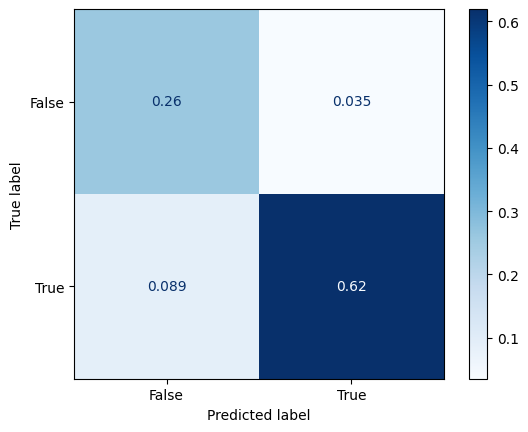

In [124]:
# Confusion matrix of Results from Multinominal Naive Bayes (mnb)
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, mnb.predict(x_test), normalize="all")
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot(cmap="Blues")
plt.show()

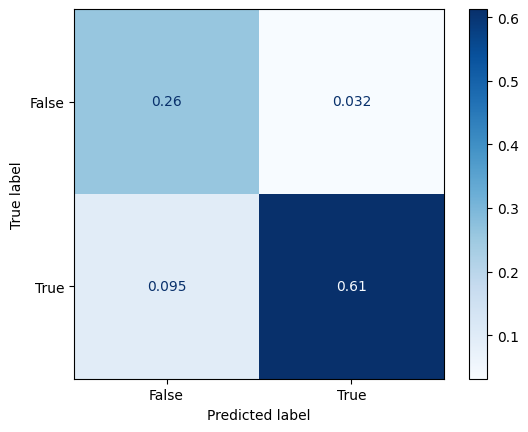

In [123]:
# Confusion matrix of Results from Complement Naive Bayes (cnb)
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, cnb.predict(x_test), normalize="all")
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot(cmap="Blues")
plt.show()